In [1]:
## Try prediction just using a recursive network 
from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import csv

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def get_session():
    """Create a session that dynamically allocates memory."""
    # See: https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


(10910, 1)
(10910, 6)
Training vs. Validation sets:


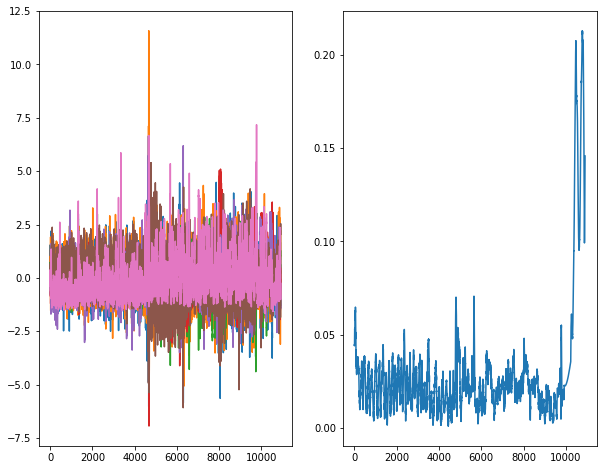

In [2]:
# Import chelsea's data
# Check times versus times.csv
# [t, x_tango, y_tango, z_tango, x_vicon, y_vicon, z_vicon, x_err_rate, y_err_rate, z_err_rate]
# Error rates, xyz
d_raw = (np.genfromtxt('trasnformed_data_slash_2.csv',delimiter=',')).astype(np.float32)
t_raw = d_raw[:,0]
t_img = (np.genfromtxt('rates.csv',delimiter=',')[:,0]).astype(np.float32)

## Align start of data streams
i_start = 0
for k in range(t_img.shape[0]):
    if(t_img[k]>t_raw[0]):
        i_start = k
        break
if i_start is 0:
    print('Warning! Time sequence alignment failed!')

# Extract and interpolate data
t_img = t_img[i_start:]
imu_data = (np.genfromtxt('rates.csv', delimiter=',')[i_start:,1:7]).astype(np.float32)
y_data = np.array([np.interp(t_img, t_raw, d_raw[:,7]), np.interp(t_img, t_raw, d_raw[:,8]), np.interp(t_img, t_raw, d_raw[:,9])]).T

# Should really automate this... or just re-save file.
flows_data = []
flows_data.append(np.load('flows_lowres_1_16.npy'))
flows_data.append(np.load('flows_lowres_2_16.npy'))
flows_data.append(np.load('flows_lowres_3_16.npy'))
flows_data.append(np.load('flows_lowres_4_16.npy'))
flows_data.append(np.load('flows_lowres_5_16.npy'))
flows_data.append(np.load('flows_lowres_6_16.npy'))
flows_data.append(np.load('flows_lowres_7_16.npy'))
flows_data.append(np.load('flows_lowres_8_16.npy'))
flows_data.append(np.load('flows_lowres_9_16.npy'))
flows_data.append(np.load('flows_lowres_10_16.npy'))
flows_data.append(np.load('flows_lowres_11_16.npy'))
flows_data.append(np.load('flows_lowres_12_16.npy'))
flows_data.append(np.load('flows_lowres_13_16.npy'))
flows_data.append(np.load('flows_lowres_14_16.npy'))
flows_data.append(np.load('flows_lowres_15_16.npy'))
flows_data.append(np.load('flows_lowres_16_16.npy'))
flows_data = np.concatenate(flows_data,axis=0)
flows_data = flows_data[i_start:,:,:,:]


# Shorten datastream:
i_start = 600 # remove initial weird-ness
i_end = flows_data.shape[0]
y_data = y_data[i_start:i_end,:]
imu_data = imu_data[i_start:i_end,:]
flows_data = flows_data[i_start:i_end,:,:,:]

# Flatten flows data into a "velocity" estimate
v = np.zeros((flows_data.shape[0],1))
for k in range(v.shape[0]):
    v[k,0] = np.linalg.norm(flows_data[k,:,:,:])

y_norm = np.zeros(y_data.shape[0]);
for k in range(y_data.shape[0]):
    y_norm[k] = np.linalg.norm(y_data[k,:])
y_data = y_norm

# Normalize imu data:
imu_data = imu_data - imu_data.mean(axis=0)
imu_data /= np.std(imu_data,axis=0)

# Normalize image data
v -= v.mean(axis=0)
v /= np.std(v,axis=0)

print(v.shape)
print(imu_data.shape)
x_data = np.concatenate([imu_data, v],axis=1)

N_training = int(0.6*x_data.shape[0])
N_validation = x_data.shape[0]- N_training
training_data_indices = np.random.choice(np.arange(x_data.shape[0]), N_training)
validation_data_indices = np.setdiff1d(np.arange(x_data.shape[0]), training_data_indices)


# sample batch_size subsequences of length sequence_length, and return the label at the end of the sequence
# These need to be randomized more - getting unwanted structure in the train/val split
def sample_minibatch(sequence_length, train=True,iseq=None):
    x_batch = np.zeros((sequence_length, x_data.shape[1]))
    y_batch = np.zeros(sequence_length)
    
    MAX_REPS=1000
    rep =0
    if(iseq is None):
        if(train):
            i_stop = 0
            while np.min(i_stop) - sequence_length < 0 or np.max(i_stop) + sequence_length >= y_data.shape[0]:
                rep+=1
                if(rep > MAX_REPS):
                    print('Stuck!', i_stop, sequence_length, y_data.shape[0]);
                    return [],[],[]
                i_stop = training_data_indices[np.random.randint(0,N_training,sequence_length)]
#                i_stop = np.random.randint(0,N_training)
        else:
            i_stop = 0
            while np.min(i_stop) - sequence_length < 0 or np.max(i_stop) + sequence_length >= y_data.shape[0]:
                rep+=1
                if(rep > MAX_REPS):
                    print('Stuck!', i_stop, sequence_length, y_data.shape[0]);
                    return [],[],[]
#                i_stop = N_training + np.random.randint(0,N_validation)
                i_stop = validation_data_indices[np.random.randint(0,N_validation,sequence_length)]
    else:
        i_stop = iseq
    
    x_batch = x_data[i_stop,:]
    y_batch = y_data[i_stop]
    return x_batch, y_batch, i_stop

def calc_rmse(predictions, targets):
    
    return np.sqrt(((predictions.reshape([-1]) - targets.reshape([-1])) ** 2).mean())

print('Training vs. Validation sets:')
plt.subplot(1,2,1)
plt.plot(x_data)
plt.subplot(1,2,2)
plt.plot(y_data)
plt.show()

In [11]:
# Definition of network:
# rescale the images ~ 64x48
# Try normalizing 
# feed output back in
# see if you can get cats roughly hte same size

OUTPUT_DIM = 1
BATCH_SIZE = 1  # Number of independent samples
R_HISTORY = 4  # length of the time series inputs
N_HIDDEN = 128 # Size of LSTM hidden layer

sub_batches = R_HISTORY*np.ones(BATCH_SIZE)

class tangoNet(object):

    # Extract features for a single time step
    def extract_features(self, input_data=None, reuse=True):
        if input_data is None:
            input_data = self.data
        x_r = input_data
        
        layers = []
        with tf.variable_scope('features', reuse=reuse):
            with tf.variable_scope('dense_1'):
                x_r = tf.layers.dense(x_r, 32, activation=tf.nn.relu)
                layers.append(x_r)
            return layers

    def __init__(self, batch_size, save_path=None, sess=None):
        self.batch_size = tf.constant(batch_size,dtype=tf.int32)
        # r_depth, batch, input_dim
        self.data   = tf.placeholder('float',shape=[R_HISTORY*batch_size,7],name='input_data_seq')
        # batch, output_dim
#        self.errs  = tf.placeholder('float',shape=[R_HISTORY*batch_size, OUTPUT_DIM],name='output_error')
        self.errs  = tf.placeholder('float',shape=[R_HISTORY*batch_size],name='output_error')
        self.lr = tf.placeholder('float',shape=[1],name='lr')
        self.state = tf.placeholder('float', shape=[N_HIDDEN],name='cell_state')

        self.layers = []
        self.features = []
        for k in range(R_HISTORY):
            data = self.data[batch_size*k:batch_size*(k+1),:]
            r = (k!=0)
            self.features.append(self.extract_features(data, reuse=r)[-1])
        
        with tf.variable_scope('core_lstm'):
            with tf.variable_scope('core_0'):
                x_r = self.features
                self.layers.append(x_r)
            with tf.variable_scope('core_1'):
                lstm_cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(N_HIDDEN),tf.contrib.rnn.BasicLSTMCell(N_HIDDEN),tf.contrib.rnn.BasicLSTMCell(N_HIDDEN)])
#                lstm_cell = tf.contrib.rnn.BasicLSTMCell(N_HIDDEN)
                x_r, states = tf.contrib.rnn.static_rnn(lstm_cell, x_r, dtype=tf.float32, sequence_length=sub_batches)
                self.layers.append(x_r[-1])
                x_r = tf.concat(x_r, axis=0)                
            with tf.variable_scope('core_end'):
                W = tf.get_variable("weights", shape=[N_HIDDEN,OUTPUT_DIM])
                b = tf.get_variable("bias", shape=[OUTPUT_DIM])
                x_r = tf.matmul(x_r, W) + b
                self.layers.append(x_r)
        self.states = states
        self.prediction = tf.reshape(x_r, [-1, OUTPUT_DIM])

        if save_path is not None:
            saver = tf.train.Saver()
            saver.restore(sess, save_path)
        # Needs a bit of work still
        self.rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(self.errs[-1], self.prediction[-1])))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.lr[0]).minimize(self.rmse)


initializing...
Training
100
200
300
400
Step:  500  MSE:  0.00766793  Val:  0.0128341316245 LR:  0.0096059601


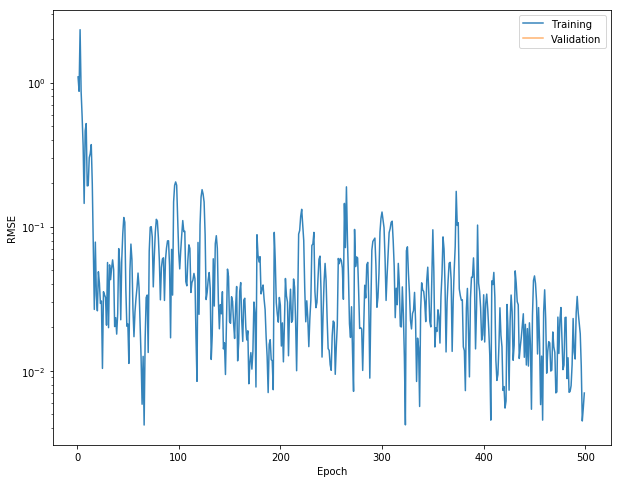

500
600
700
800
900
Step:  1000  MSE:  0.0142231  Val:  0.0138480914757 LR:  0.009135172474836408


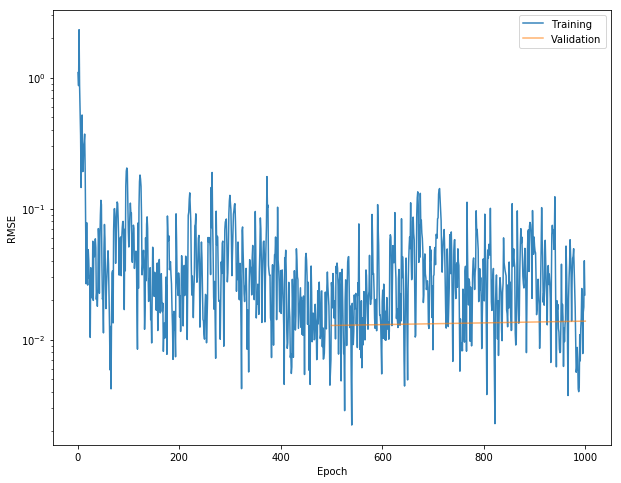

1000
1100
1200
1300
1400
Step:  1500  MSE:  0.0389468  Val:  0.0309099407867 LR:  0.008687458127689783


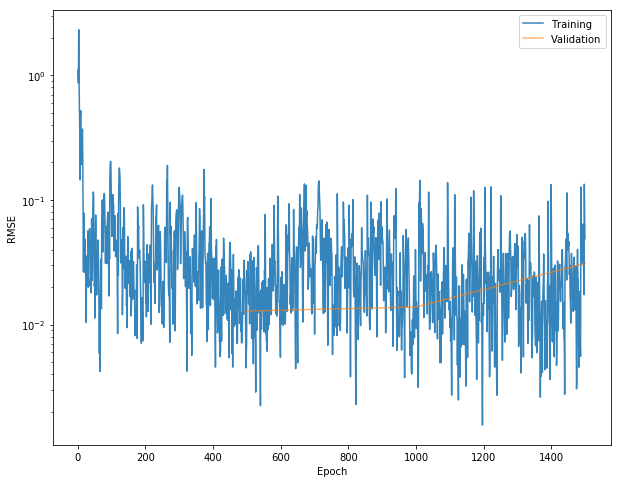

1500
1600
1700
1800
1900
Step:  2000  MSE:  0.00488115  Val:  0.00810298267752 LR:  0.008261686238355867


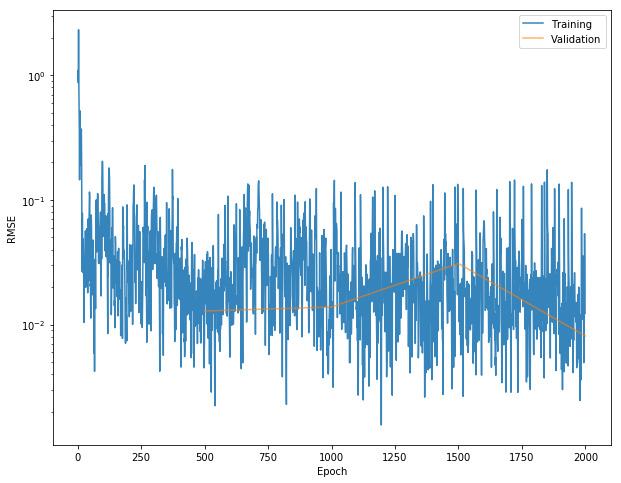

2000
2100
2200
2300
2400
Step:  2500  MSE:  0.0225589  Val:  0.0123734193854 LR:  0.007856781408072189


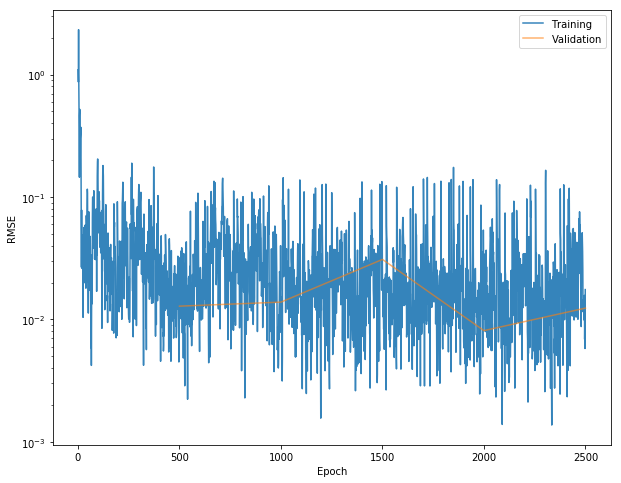

2500
2600
2700
2800
2900
Step:  3000  MSE:  0.0126268  Val:  0.00925429323688 LR:  0.007471720943315963


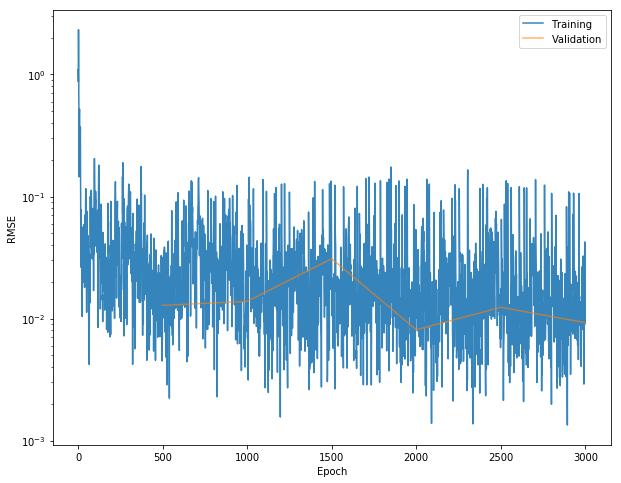

3000
3100
3200
3300
3400
Step:  3500  MSE:  0.0159003  Val:  0.00855288403109 LR:  0.007105532272722923


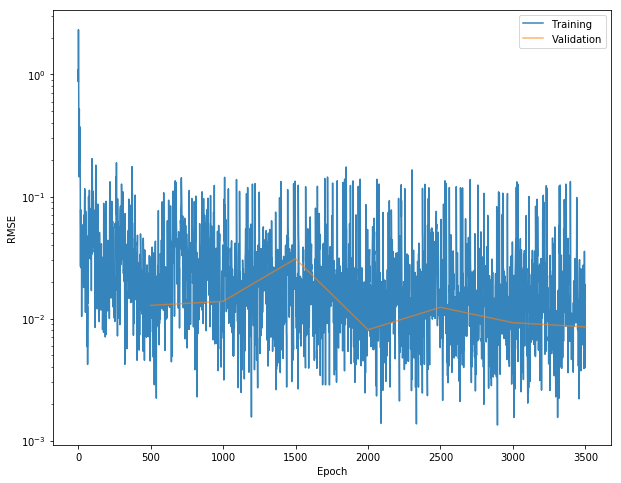

3500
3600
3700
3800
3900
Step:  4000  MSE:  0.00125122  Val:  0.0127784982324 LR:  0.0067572904906028335


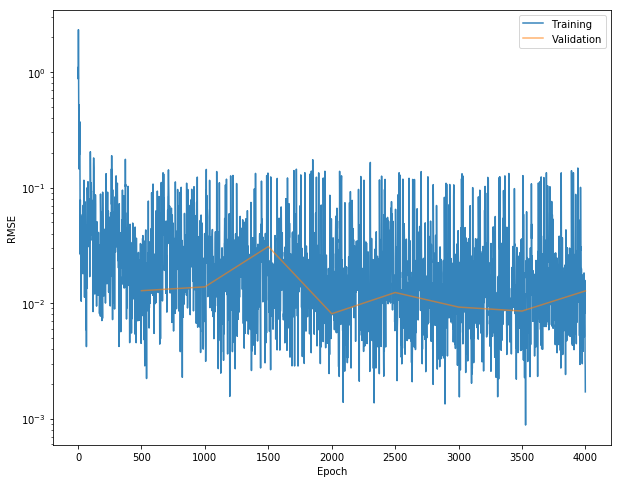

4000
4100
4200
4300
4400
Step:  4500  MSE:  0.0173375  Val:  0.0142644928768 LR:  0.006426116020847182


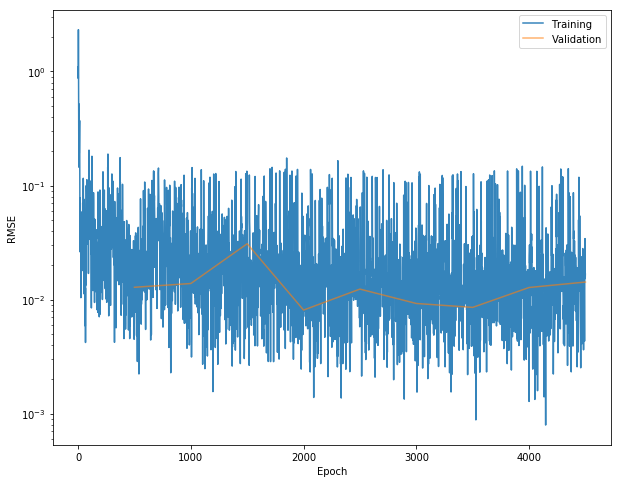

4500
4600
4700
4800
4900
Step:  5000  MSE:  0.0145477  Val:  0.0265249179676 LR:  0.006111172395328651


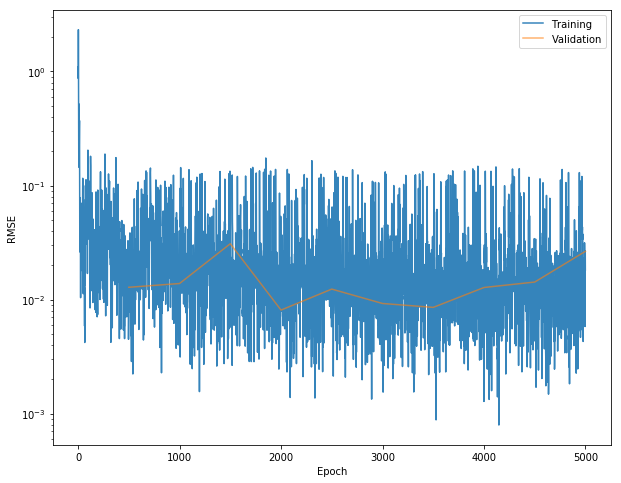

5000
5100
5200
5300
5400
Step:  5500  MSE:  0.00231161  Val:  0.010840719007 LR:  0.005811664141181096


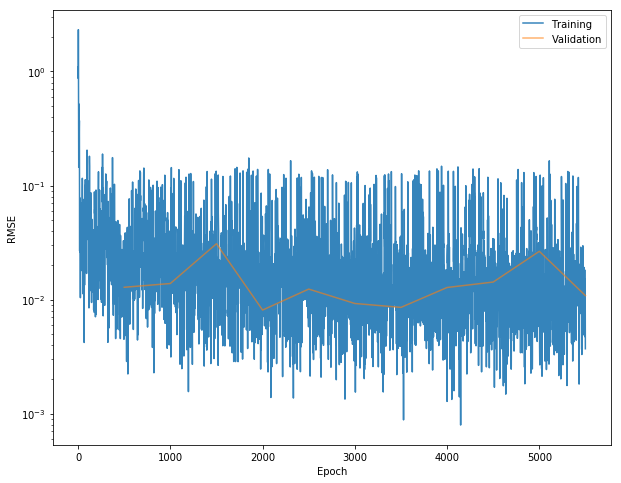

5500
5600
5700
5800
5900
Step:  6000  MSE:  0.00386836  Val:  0.0143797714263 LR:  0.0055268347716238495


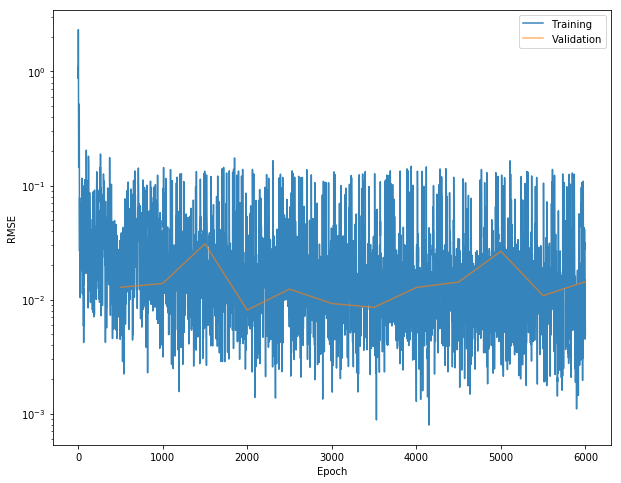

6000
6100
6200
6300
6400
Step:  6500  MSE:  0.0175681  Val:  0.00889161722735 LR:  0.00525596487525562


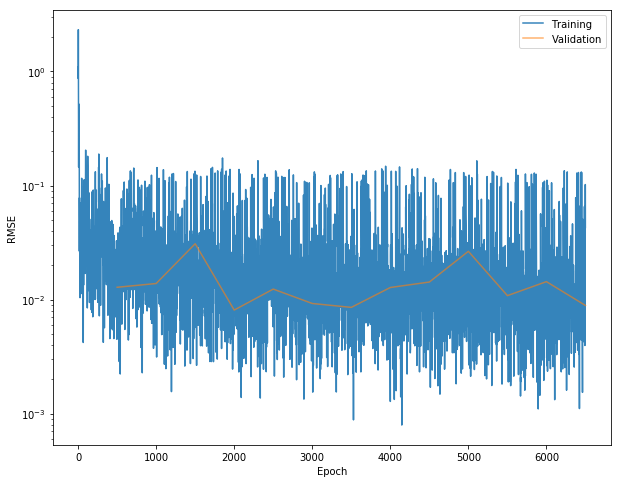

6500
6600
6700
6800
6900
Step:  7000  MSE:  0.0204213  Val:  0.017007420864 LR:  0.004998370298991989


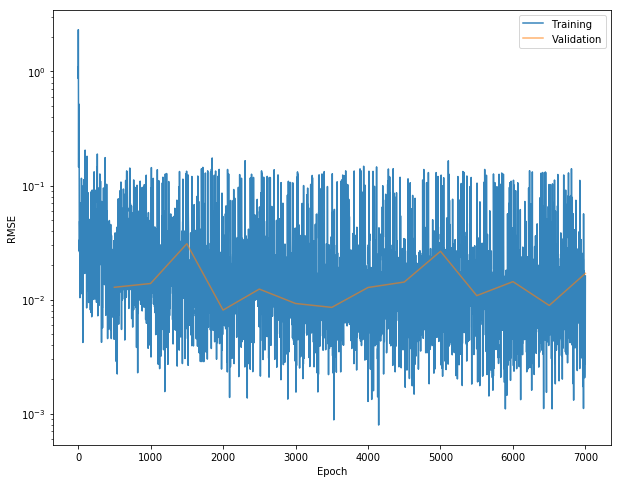

7000
7100
7200
7300
7400
Step:  7500  MSE:  0.000876257  Val:  0.0136682646349 LR:  0.0047534004200570695


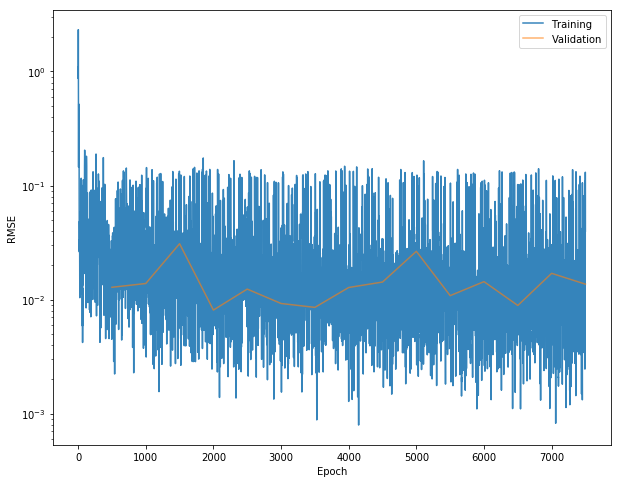

7500
7600
7700
7800
7900
Step:  8000  MSE:  0.00305931  Val:  0.0159675301984 LR:  0.004520436502664754


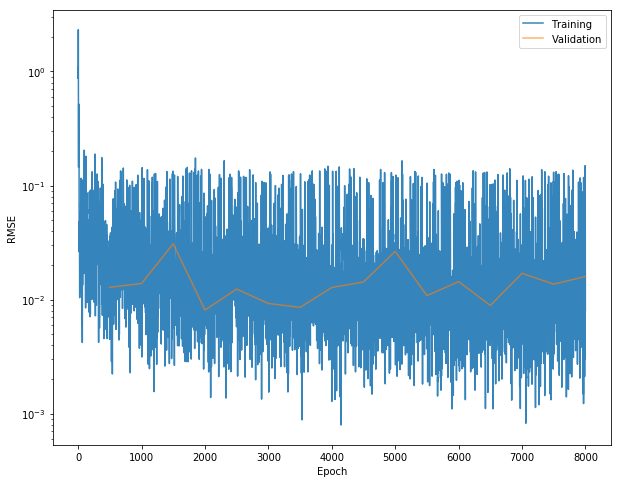

8000
8100
8200
8300
8400
Step:  8500  MSE:  0.00663262  Val:  0.0108874403872 LR:  0.004298890135238936


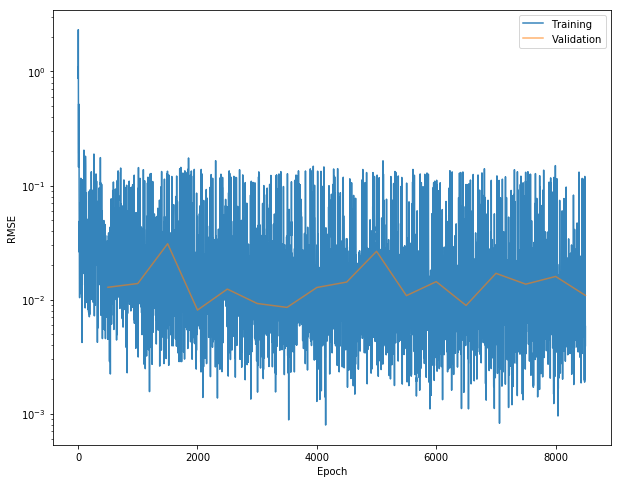

8500
8600
8700
8800
8900
Step:  9000  MSE:  0.0134965  Val:  0.0194652039558 LR:  0.004088201744225493


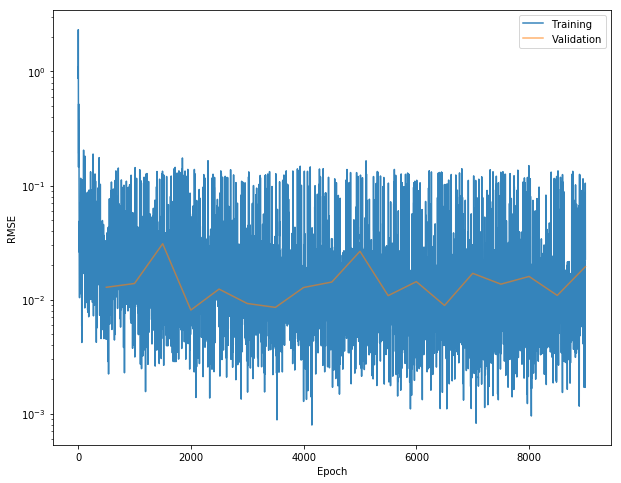

9000
9100
9200
9300
9400
Step:  9500  MSE:  0.013344  Val:  0.00853759376332 LR:  0.0038878391807422685


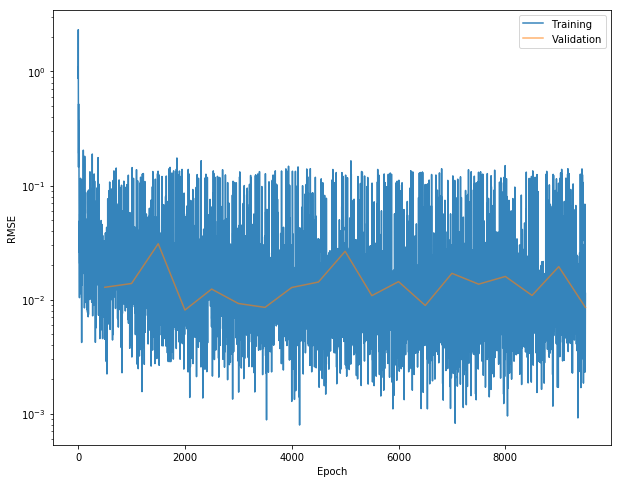

9500
9600
9700
9800
9900
Step:  10000  MSE:  0.0131473  Val:  0.012427734118 LR:  0.003697296376497265


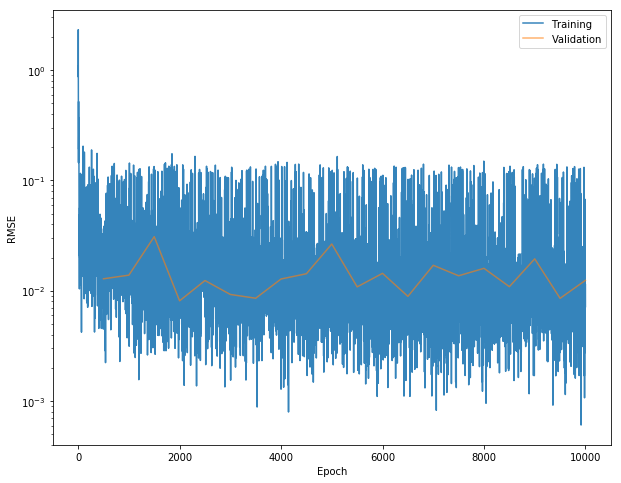

In [13]:
# simple parameters:
disp_period = 500
training_iters = 10000
#lr = 0.00001
#lr_decay=0.99


print('initializing...')
lr = 0.01
lr_decay = 0.99
with tf.device('/cpu:0'):
    tf.reset_default_graph()
    sess = get_session()
    SAVE_PATH = '/media/Big_Data/stefantj/tangonet.ckpt'

    model = tangoNet(batch_size = BATCH_SIZE, sess=sess)

        # Initializing the variables
    init = tf.global_variables_initializer()

    train_history = []
    val_history = []
    naive_history = []
    
    # Launch the graph
    sess.run(init)
    step = 1
    ind_train = []
    train_inds = []
    val_inds = []
    print('Training')
    # Keep training until reach max iterations
    state = np.zeros(N_HIDDEN);
    while step  < training_iters:
        if step % 100 is 0:
            print(step)
            lr *= lr_decay
        # these batches are of size 1?
        # for now, just grab a random sequence of data:
        batch_x, batch_y, istp = sample_minibatch(R_HISTORY*BATCH_SIZE)
        
        # Run optimization op (backprop)
        o,mse,state = sess.run([model.optimizer,model.rmse, model.state], feed_dict={model.state: state, model.data: batch_x, model.errs: batch_y, model.lr:[lr]})
        train_inds.append(step)
        smooth_val = 0.7
        if step > 1:
            train_history.append(mse*smooth_val + (1-smooth_val)*train_history[-1])
        else:
            train_history.append(mse)
            
        step += 1
        if step % disp_period is 0:
            # Calculate val accuracy:
            N_smooth = 10;
            batch_x, batch_y, istp = sample_minibatch(R_HISTORY*BATCH_SIZE, False)
            state_copy = state.copy()
            vmse = sess.run(model.rmse, feed_dict={model.state: state_copy,model.data: batch_x, model.errs: batch_y})
            val_history.append(vmse/N_smooth)
            val_inds.append(step)
            
            for smooth_num in range(N_smooth-1):
                batch_x, batch_y, istp = sample_minibatch(R_HISTORY*BATCH_SIZE, False)
                vmse = sess.run(model.rmse, feed_dict={model.state: state_copy,model.data: batch_x, model.errs: batch_y})
                val_history[-1]+=(vmse/N_smooth)

            
            print('Step: ', step, ' MSE: ', mse, ' Val: ', val_history[-1], 'LR: ', lr)
            plt.semilogy(train_inds, train_history,alpha=0.9)
            plt.semilogy(val_inds, val_history,alpha=0.6)
            plt.legend(['Training','Validation'])
            plt.xlabel('Epoch')
            plt.ylabel('RMSE')
            plt.show()


Computing sequence prediction - this may take a while. 
k =  1000
k =  2000
k =  3000
k =  4000
k =  5000
k =  6000
k =  7000
k =  8000
k =  9000
k =  10000
Done.
plotting from  300  to  1500
High correlation (near 1) means we are predicting well.
Correlation between error and signal: 0.0332993231787


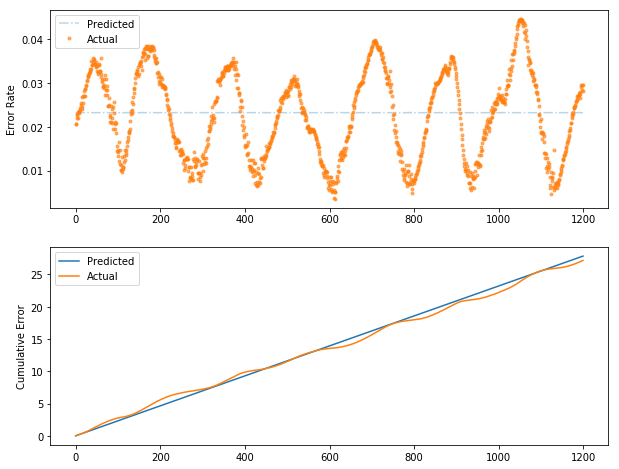

High correlation (near 1) means we are predicting noise.
Correlation between error and signal: 0.999998439449


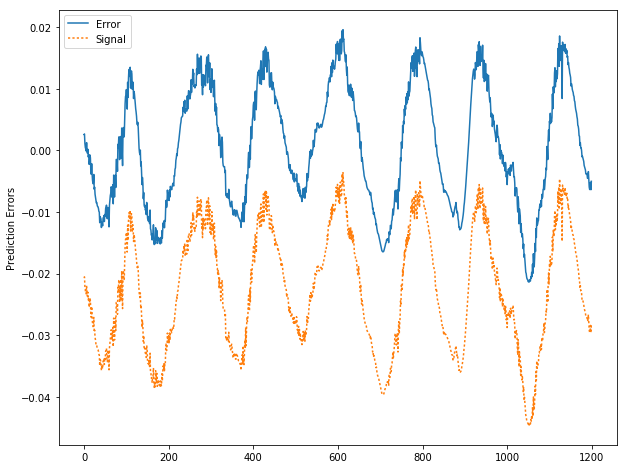

In [16]:
# Can load a previously computed prediction - useful if cold starting a notebook.

# Compute sequence prediction:
print('Computing sequence prediction - this may take a while. ')
state = np.zeros(N_HIDDEN)
m_state = np.zeros(y_data.shape[0])
y_pred = np.zeros(y_data.shape[0])
for k in range(BATCH_SIZE*R_HISTORY, flows_data.shape[0]):
    if k % 1000 is 0:
        print('k = ', k)
    batch_x, batch_y, istp = sample_minibatch(R_HISTORY*BATCH_SIZE, k)
    pred,state = sess.run([model.prediction,model.state], feed_dict={model.state:state,model.data: batch_x, model.errs: batch_y})
    m_state[k] = np.max(state)
    y_pred[k] = pred[-1]
np.save('rnn_prediction', y_pred)
print('Done.')

# Blue background corresponds to data used during training
def plot_data(ns, ne):    

    print('plotting from ', ns, ' to ', ne)
    
    print('High correlation (near 1) means we are predicting well.')
    m1 = y_data[ns:ne].mean()
    c1 = np.sqrt(np.correlate(y_data[ns:ne]-m1,y_data[ns:ne]-m1)[0])
    m2 = y_pred[ns:ne].mean()
    c2 = np.sqrt(np.correlate(y_pred[ns:ne]-m2,y_pred[ns:ne]-m2)[0])
    c12 = (np.correlate(y_data[ns:ne]-m1,y_pred[ns:ne]-m2))[0]/(c1*c2)
    print('Correlation between error and signal:', (np.abs(c12)))
    
    plt.subplot(2,1,1)
    plt.ylabel('Error Rate')
    plt.plot(y_pred[ns:ne],'-.',alpha=0.3)
    plt.plot(y_data[ns:ne],'.',alpha=0.6)
#        plt.axvspan(0,N_training, facecolor='b',alpha=0.1)
    plt.legend(['Predicted','Actual'])

    plt.subplot(2,1,2)
    plt.ylabel('Cumulative Error')
    plt.plot(np.cumsum(y_pred[ns:ne]))
    plt.plot(np.cumsum(y_data[ns:ne]))
#        plt.axvspan(0,N_training, facecolor='b',alpha=0.1)
    plt.legend(['Predicted','Actual'])
    plt.savefig('rnn_performance.png',dpi=1080)
    plt.show()

def plot_error(ns, ne):
    print('High correlation (near 1) means we are predicting noise.')
    m1 = y_data[ns:ne].mean()
    c1 = np.sqrt(np.correlate(y_data[ns:ne]-m1,y_data[ns:ne]-m1)[0])
    m2 = np.mean(y_pred[ns:ne]-y_data[ns:ne])
    c2 = np.sqrt(np.correlate(y_pred[ns:ne]-m2-y_data[ns:ne],y_pred[ns:ne]-m2-y_data[ns:ne])[0])
    c12 = (np.correlate(y_data[ns:ne]-m1,y_pred[ns:ne]-y_data[ns:ne]-m2))[0]/(c1*c2)
    print('Correlation between error and signal:', (np.abs(c12)))
    
    plt.ylabel('Prediction Errors')
    plt.plot(y_pred[ns:ne]-y_data[ns:ne])
    plt.plot(-y_data[ns:ne],':')
    plt.legend(['Error', 'Signal'])
    plt.show()


#plt.title('Learning Curve')
#naive_val = 0
#for k in range(y_data.shape[0]):
#    naive_val += calc_rmse(y_data[k,:],np.zeros(OUTPUT_DIM))
#naive_val /= y_data.shape[0]

#plt.plot(train_history,'.',alpha=0.3)
#plt.plot(val_history,'.',alpha=0.3)
#plt.plot(naive_val*np.ones_like(train_history),':')
#plt.legend(['Training','Validation','Naive'])
#plt.xlabel('Epoch')
#plt.ylabel('RMSE')
#plt.show()


data_length = y_data.shape[0]
plot_data(300,1500)
plot_error(300,1500)


plotting from  300  to  500
High correlation (near 1) means we are predicting well.
Correlation between error and signal: 0.0371808338265


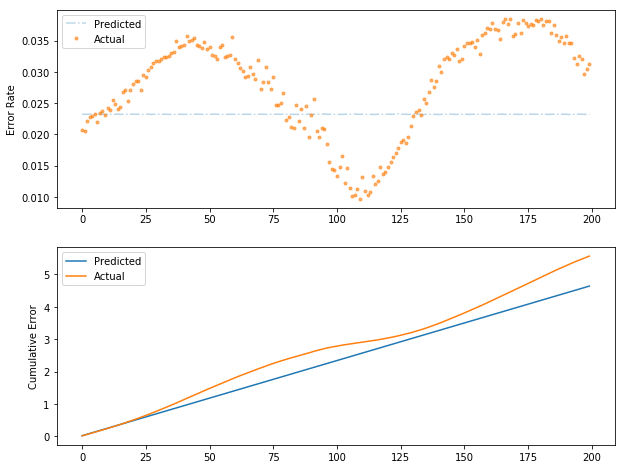

High correlation (near 1) means we are predicting noise.
Correlation between error and signal: 0.999996876751


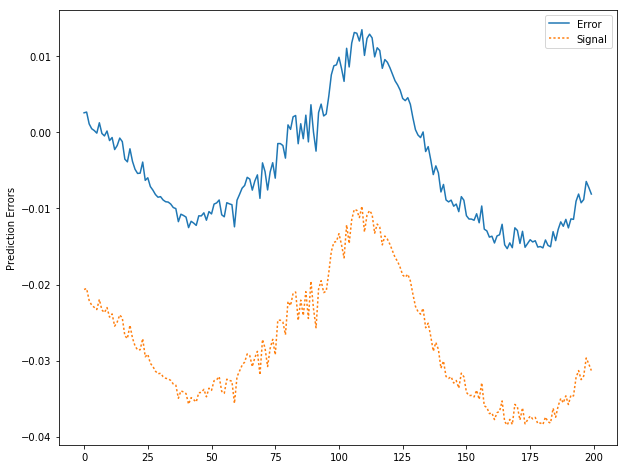

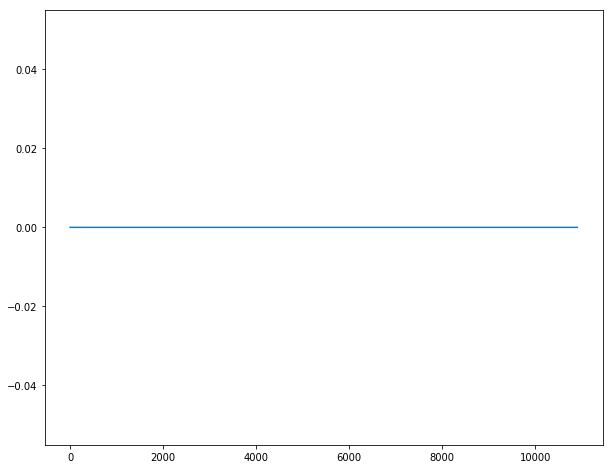

In [17]:
plot_data(300,500)
plot_error(300,500)
plt.plot(m_state)